In [1]:
import sys
import os
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Path setup
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from scripts.loader import DataLoader
from scripts.cleaner import DataCleaner
from scripts.feature_engineering import FeatureEngineer
from scripts.modeling import ModelTrainer

%load_ext autoreload
%autoreload 2

FILE_PATH = '../data/MachineLearningRating_v3.txt'

/Users/mac/Documents/kaim/week3/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Load
loader = DataLoader(FILE_PATH)
df_raw = loader.load_data()

# 2. Clean
cleaner = DataCleaner(df_raw)
cleaner.convert_to_numeric(['TotalPremium', 'TotalClaims', 'CustomValueEstimate'])
df = cleaner.get_cleaned_data()

# 3. Feature Engineering
engineer = FeatureEngineer(df)
df = engineer.create_features() # Adds VehicleAge, IsClaimed

# Select Features for Modeling
# We drop IDs and Dates to prevent overfitting to specific IDs
cols_to_drop = ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'VehicleIntroDate', 'PostalCode', 'mmcode']
cat_cols = ['Province', 'VehicleType', 'make', 'Gender', 'MaritalStatus', 'BodyType', 'CoverType']

# Encode Categoricals
df_encoded = engineer.encode_categorical(cat_cols)

print("Preprocessing Complete.")
df_encoded.head()

🔄 Loading data from ../data/MachineLearningRating_v3.txt...
✅ Data loaded successfully! Shape: (1000100, 52)


/Users/mac/Documents/kaim/week3/scripts/feature_engineering.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df['VehicleIntroDate'] = pd.to_datetime(self.df['VehicleIntroDate'], errors='coerce')


Preprocessing Complete.


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,VehicleAge,IsClaimed
0,145249,12827,2015-03-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,21,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,13.166324,0
1,145249,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,21,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,13.166324,0
2,145249,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,21,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,13.166324,0
3,145255,12827,2015-05-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,13,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,13.166324,0
4,145255,12827,2015-07-01,True,,Close Corporation,Mr,English,First National Bank,Current account,...,13,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,13.166324,0


In [3]:
# 1. Prepare Data (Filter claims > 0)
X_reg, y_reg = engineer.prepare_data_for_modeling(
    target_col='TotalClaims', 
    drop_cols=cols_to_drop + ['IsClaimed', 'Margin'], # Drop helper cols
    filter_claims=True
)

# 2. Train Models
print(f"Training Regression on {X_reg.shape[0]} claimed policies...")
reg_trainer = ModelTrainer(X_reg, y_reg, task='regression')
reg_trainer.train_models()

# 3. Evaluate
results_reg = reg_trainer.evaluate()

Training Regression on 2788 claimed policies...
🚀 Training Models for regression...
📊 LinearRegression: RMSE=33700.48, R2=0.2938
📊 RandomForest: RMSE=35994.47, R2=0.1944
📊 GradientBoosting: RMSE=38392.59, R2=0.0835


In [4]:
# 1. Prepare Data (All Rows)
# Note: target_col is 'IsClaimed', we drop 'TotalClaims' to avoid data leakage
X_clf, y_clf = engineer.prepare_data_for_modeling(
    target_col='IsClaimed', 
    drop_cols=cols_to_drop + ['TotalClaims', 'Margin'],
    filter_claims=False
)

# 2. Train Models
print(f"Training Classification on {X_clf.shape[0]} policies...")
clf_trainer = ModelTrainer(X_clf, y_clf, task='classification')
clf_trainer.train_models()

# 3. Evaluate
results_clf = clf_trainer.evaluate()

Training Classification on 1000100 policies...
🚀 Training Models for classification...
📊 RandomForest Accuracy: 84.43%
📊 GradientBoosting Accuracy: 99.72%


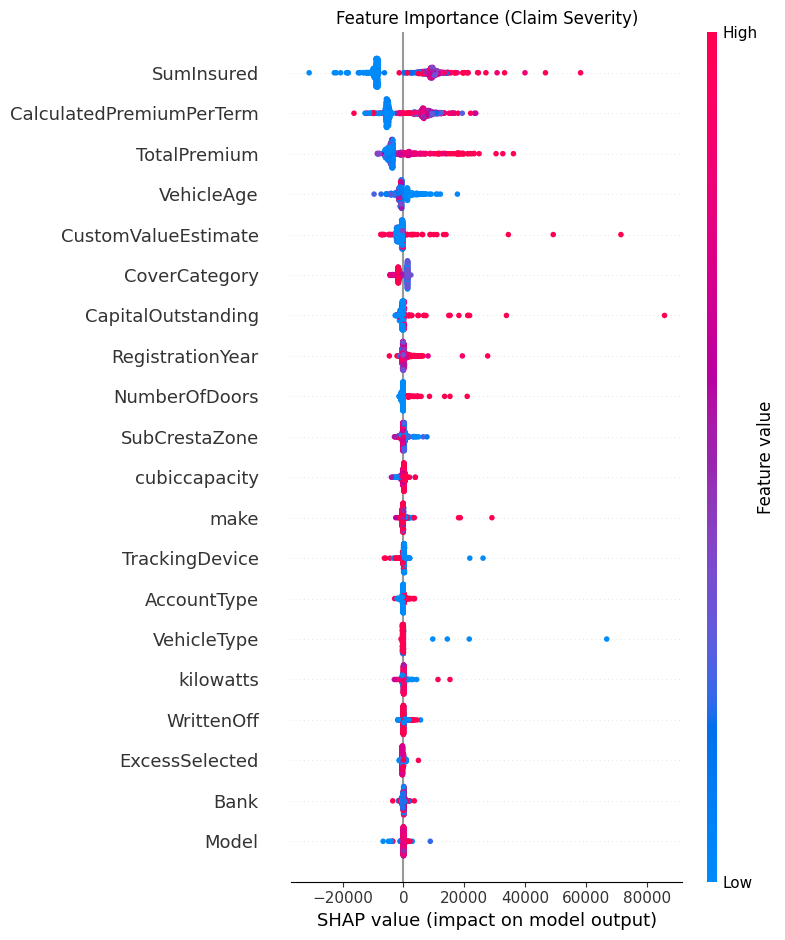

In [5]:
# Get the XGBoost model from the Regression experiment
best_model = reg_trainer.get_best_model()

# Create SHAP Explainer
explainer = shap.Explainer(best_model)
shap_values = explainer(reg_trainer.X_test)

# Plot Summary
plt.title("Feature Importance (Claim Severity)")
shap.summary_plot(shap_values, reg_trainer.X_test)